# Before you start

Before you review this notebook, please spend an hour or two on your own familiarizing yourself with the data, thinking about the problem, and the approach you would like to take.  If you just jump into the starter code, you will miss out on your own creative thinking, and limit yourself to what you see here.   

***

**First, some library imports**

In [589]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay, precision_score, recall_score
from tqdm import tqdm


# Complaints dataset from CFPB  
## Load the data  
First, we load the dataset.  We use the file in the `shared\` folder.

**To load the data directly from the CFPB website, use the below command.  Be aware you will get lots of data!**
**You will then need to filter it for just the 5 banks we are interested in analyzing.**
```
complaints = pd.read_csv(r'https://files.consumerfinance.gov/ccdb/complaints.csv.zip')
```

For this exercise, we will use the data from the provided file.  This file is in the /shared folder on Jupyterhub.  If the next cell returns an error, add `shared/` before the file name.

In [590]:
# Load dataset from provided file
complaints = pd.read_csv('complaints.csv')

## Review the data
The next few cells look at the data in a couple of different ways.  This does not cover graphing and visualization, but you should do that.

In [591]:
# How many rows and columns do we have?

complaints.shape

(207260, 18)

In [592]:
# What are the column names?

complaints.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [593]:
# Let us look at which banks have the most number of complaints

complaints['Company'].value_counts().sort_values(ascending=False)

Company
BANK OF AMERICA, NATIONAL ASSOCIATION    65440
WELLS FARGO & COMPANY                    53111
JPMORGAN CHASE & CO.                     42170
CITIBANK, N.A.                           34341
U.S. BANCORP                             12198
Name: count, dtype: int64

**Note:**  
If you are using the file directly from the CFPB website, you will need to run the below commands as we want to analyze only the top-5 banks.  But if you are using the pre-provided file, you do not need to run the code below.
```
banks = ['BANK OF AMERICA, NATIONAL ASSOCIATION', 'WELLS FARGO & COMPANY','JPMORGAN CHASE & CO.', 'CITIBANK, N.A.' , 'U.S. BANCORP']
filtered = complaints[(complaints['Company'].isin(banks))]
filtered.to_csv("complaints_14Nov21.csv", index=False)
```

In [594]:
# Let us get a feel for the data

complaints

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2016-10-26,Money transfers,International money transfer,Other transaction issues,NaN,"To whom it concerns, I would like to file a fo...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NaN,NaN,NaN,Consent provided,Web,2016-10-29,Closed with explanation,Yes,No,2180490
1,2015-03-27,Bank account or service,Other bank product/service,"Account opening, closing, or management",NaN,My name is XXXX XXXX XXXX and huband name is X...,Company chooses not to provide a public response,"CITIBANK, N.A.",PA,151XX,Older American,Consent provided,Web,2015-03-27,Closed with explanation,Yes,No,1305453
2,2015-04-20,Bank account or service,Other bank product/service,"Making/receiving payments, sending money",NaN,XXXX 2015 : I called to make a payment on XXXX...,Company chooses not to provide a public response,U.S. BANCORP,PA,152XX,NaN,Consent provided,Web,2015-04-22,Closed with monetary relief,Yes,No,1337613
3,2013-04-29,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",NaN,NaN,NaN,JPMORGAN CHASE & CO.,VA,22406,Servicemember,NaN,Phone,2013-04-30,Closed with explanation,Yes,Yes,393900
4,2013-05-29,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",GA,30044,NaN,NaN,Referral,2013-05-31,Closed with explanation,Yes,No,418647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207255,2015-05-24,Debt collection,Credit card,Taking/threatening an illegal action,Sued w/o proper notification of suit,NaN,NaN,JPMORGAN CHASE & CO.,FL,33133,NaN,Consent not provided,Web,2015-05-24,Closed with explanation,Yes,No,1390395
207256,2012-01-10,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,JPMORGAN CHASE & CO.,NY,10312,NaN,NaN,Referral,2012-01-11,Closed without relief,Yes,Yes,12192
207257,2012-07-17,Student loan,Non-federal student loan,Repaying your loan,NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",NH,032XX,NaN,NaN,Web,2012-07-18,Closed with explanation,Yes,No,118351
207258,2016-09-29,Bank account or service,Checking account,"Account opening, closing, or management",NaN,Near the end of XXXX 2016 I opened a Citigold ...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,900XX,NaN,Consent provided,Web,2016-09-29,Closed with non-monetary relief,Yes,No,2138969


## Predicting 'Consumer Disputed'

We look at the distribution of how many people disputed the complaint's resolution versus how many did not.  

In [595]:
# Let us see how many total disputes are there

complaints['Consumer disputed?'].value_counts().sum()

207260

**The above is 207,260 records.  Which is the same as the number of records in our dataset.  That means we do not have any `NaN` values.**

In [596]:
# Split between yes and no

complaints['Consumer disputed?'].value_counts()

Consumer disputed?
No     162357
Yes     44903
Name: count, dtype: int64

In [597]:
# Same thing as a percentage

complaints['Consumer disputed?'].value_counts(normalize=True)

Consumer disputed?
No     0.783349
Yes    0.216651
Name: proportion, dtype: float64

In [598]:
# Check for NaNs in the 'Consumer Disputed' column

complaints['Consumer disputed?'].isna().sum()

0

In [599]:
# Next, for cleanliness we change the column type for 'Consumer Disputed' from string to category
# We don't have to do this, but can't hurt just in case an algorithm we are trying needs this.

complaints['Consumer disputed?'] = complaints['Consumer disputed?'].astype('category')

So we have an imbalanced dataset as only about 22% is in the `Yes` class.  This means we should consider rebalancing the training dataset using a technique such as SMOTE.  But we will do that after doing the train-test split.  But first, we need to think about what in our data should be the predictor variables, ie, what should be included as a feature in `X`.

## Deciding the feature set      
To do that, let us look at the dataset again.  And refer to the data-dictionary in the Word document for the project.  

|Field name  |Description  |Can it be a feature?  |
|------------  |------------  |------------  |
|Date received  |The date the CFPB received the complaint. For example, “05/25/2013.”  |Not a feature  |
|Product  |The type of product the consumer identified in the complaint. For example, “Checking or savings account” or “Student loan.”  |Yes  |
|Sub-product  |The type of sub-product the consumer identified in the complaint. For example, “Checking account” or “Private student loan.”  |Yes  |
|Issue  |The issue the consumer identified in the complaint. For example, “Managing an account” or “Struggling to repay your loan.”  |Yes  |
|Sub-issue  |The sub-issue the consumer identified in the complaint. For example, “Deposits and withdrawals” or “Problem lowering your monthly payments.”  |Yes  |
|Consumer complaint narrative  |Consumer complaint narrative is the consumer-submitted description of “what happened” from the complaint. Consumers must opt-in to share their narrative. We will not publish the narrative unless the consumer consents, and consumers can opt-out at any time. The CFPB takes reasonable steps to scrub personal information from each complaint that could be used to identify the consumer.  |Maybe, if we can convert text to some vector form  |
|Company public response  |The company’s optional, public-facing response to a consumer’s complaint. Companies can choose to select a response from a pre-set list of options that will be posted on the public database. For example, “Company believes complaint is the result of an isolated error.”  |Yes  |
|Company  |The complaint is about this company. For example, “ABC Bank.”  |Yes  |
|State  |The state of the mailing address provided by the consumer.  |Yes  |
|ZIP code  |The mailing ZIP code provided by the consumer. This field may: i) include the first five digits of a ZIP code; ii) include the first three digits of a ZIP code (if the consumer consented to publication of their complaint narrative); or iii) be blank (if ZIP codes have been submitted with non-numeric values, if there are less than 20,000 people in a given ZIP code, or if the complaint has an address outside of the United States).  |Yes  |
|Tags  |Data that supports easier searching and sorting of complaints submitted by or on behalf of consumers. For example, complaints where the submitter reports the age of the consumer as 62 years or older are tagged “Older American.” Complaints submitted by or on behalf of a servicemember or the spouse or dependent of a servicemember are tagged “Servicemember.” Servicemember includes anyone who is active duty, National Guard, or Reservist, as well as anyone who previously served and is a veteran or retiree.  |Yes  |
|Consumer consent provided?  |Identifies whether the consumer opted in to publish their complaint narrative. We do not publish the narrative unless the consumer consents, and consumers can opt-out at any time.  |Yes  |
|Submitted via  |How the complaint was submitted to the CFPB. For example, “Web” or “Phone.”  |Yes  |
|Date sent to company  |The date the CFPB sent the complaint to the company.  |Not relevant  |
|Company response to consumer  |This is how the company responded. For example, “Closed with explanation.”  |Yes  |
|Timely response?  |Whether the company gave a timely response. For example, “Yes” or “No.”  |Yes  |
|Consumer disputed?  |Whether the consumer disputed the company’s response.  |This the Target  |
|Complaint ID  |The unique identification number for a complaint.  |Not a feature  |


To begin with, let us ignore the text contained in 'Consumer complaint narrative' and look at the rest of the features.  We can come back to this later.

In [600]:
X = complaints[[ 'Product', 'Sub-product', 'Issue', 'Sub-issue',
        'Company public response', 'Company',
       'State',  'Tags',
       'Submitted via',  'Company response to consumer',
       'Timely response?']]

In [601]:
# Let us check if we have any missing values in our reduced dataset X

print(len(X)) # Number of rows before dropna()
print(len(X.dropna())) # Number of rows after dropna() 

207260
581


If we were to drop `NaN` values, we would be left with very few rows.  That means we need to think harder about `NaN` values.  

To do that, let us look at which columns are missing values.  

In [602]:
# Check how many values are missing in each column

X.isna().sum()

Product                              0
Sub-product                      43015
Issue                                0
Sub-issue                       196913
Company public response         148802
Company                              0
State                             2194
Tags                            178995
Submitted via                        0
Company response to consumer         0
Timely response?                     0
dtype: int64

**Now the question is: how do we deal with these missing values?  Let us look at what each of these columns contain.  We will do a `unique()` on these columns to see which are the values contained in these columns.**  

In [582]:
X['Sub-product'].unique()

array(['International money transfer', 'Other bank product/service',
       'Conventional fixed mortgage', 'Other mortgage',
       'Checking account', 'Vehicle lease', nan, 'Medical',
       'Conventional adjustable mortgage (ARM)', 'Vehicle loan',
       'Reverse mortgage', '(CD) Certificate of deposit', 'FHA mortgage',
       'Government benefit payment card', 'VA mortgage',
       'Savings account', 'Credit card',
       'Home equity loan or line of credit', 'Second mortgage',
       'Non-federal student loan', 'Installment loan',
       'Other special purpose card', 'Mortgage', 'I do not know',
       'Cashing a check without an account', 'Federal student loan',
       'Auto', 'Other (i.e. phone, health club, etc.)',
       'Personal line of credit', 'Domestic (US) money transfer',
       'General purpose card', 'Payday loan',
       'Traveler’s/Cashier’s checks', 'Refund anticipation check',
       'Federal student loan servicing', 'Debt settlement',
       'Gift or merchant card

In [583]:
X['Sub-issue'].unique()

array([nan, 'Debt is not mine', 'Not given enough info to verify debt',
       'Frequent or repeated calls', 'Account status',
       'Trouble with how payments are handled',
       'Talked to a third party about my debt', 'Debt was paid',
       'Attempted to/Collected exempt funds',
       'Right to dispute notice not received',
       'Debt was discharged in bankruptcy',
       'Seized/Attempted to seize property', 'Account terms',
       'Indicated committed crime not paying',
       'Having problems with customer service',
       'Threatened to sue on too old debt',
       'Contacted employer after asked not to',
       "Can't decrease my monthly payments",
       'Attempted to collect wrong amount',
       "Don't agree with fees charged",
       'Qualify for a better loan than offered',
       "Indicated shouldn't respond to lawsuit",
       'Received bad information about my loan',
       'Not disclosed as an attempt to collect',
       "Can't temporarily postpone payments",
   

In [584]:
X['State'].unique()

array([nan, 'PA', 'VA', 'GA', 'CA', 'MD', 'MN', 'WA', 'OK', 'TX', 'FL',
       'NJ', 'MA', 'WI', 'AZ', 'NY', 'DE', 'IL', 'CT', 'AE', 'MI', 'TN',
       'NH', 'MO', 'DC', 'OH', 'WV', 'NC', 'NM', 'AL', 'NV', 'UT', 'SC',
       'AK', 'KY', 'HI', 'OR', 'KS', 'CO', 'IN', 'ID', 'NE', 'VT', 'LA',
       'RI', 'WY', 'MS', 'ME', 'MT', 'IA', 'AR', 'PR', 'ND', 'SD', 'AS',
       'AP', 'GU', 'VI', 'MH', 'FM', 'AA', 'MP', 'PW'], dtype=object)

In [585]:
X['Company public response'].unique()

array(['Company has responded to the consumer and the CFPB and chooses not to provide a public response',
       'Company chooses not to provide a public response', nan,
       'Company believes it acted appropriately as authorized by contract or law',
       'Company believes complaint represents an opportunity for improvement to better serve consumers',
       'Company believes complaint caused principally by actions of third party outside the control or direction of the company',
       'Company believes complaint is the result of an isolated error',
       'Company believes complaint relates to a discontinued policy or procedure',
       'Company believes the complaint is the result of a misunderstanding'],
      dtype=object)

In [603]:
print(X['Tags'].unique())
X['Tags'].value_counts()


[nan 'Older American' 'Servicemember' 'Older American, Servicemember']


Tags
Older American                   18554
Servicemember                     7331
Older American, Servicemember     2380
Name: count, dtype: int64

## Dealing with missing data  
It is clear that all of these fields that have missing data are categorical, or string, and we cannot use any numerical imputation method to fill the missing values. 

What I would propose is to remove the NaNs by putting the text 'missing' in its place.  That would mean that all missing items would be treated as a category that we humans understand to be missing, but for the machine it is just another category called 'missing'.  

Of course, you are welcome to try other approaches.  

In [604]:
X = X.fillna('missing')
X.dropna().shape

(207260, 11)

## Data prep
We see that there are no cells that have NAs any more after our operations above.  So it is safe to proceed.

In [605]:
# Next, we convert all the X observations into numbers

X = pd.get_dummies(X)


In [606]:
# Let us see what X looks like

print('X has the shape ',X.shape)

X

X has the shape  (207260, 306)


,Product_Bank account or service,Product_Consumer Loan,Product_Credit card,Product_Credit reporting,Product_Debt collection,Product_Money transfers,Product_Mortgage,Product_Other financial service,Product_Payday loan,Product_Prepaid card,...,Submitted via_Web,Company response to consumer_Closed,Company response to consumer_Closed with explanation,Company response to consumer_Closed with monetary relief,Company response to consumer_Closed with non-monetary relief,Company response to consumer_Closed with relief,Company response to consumer_Closed without relief,Company response to consumer_Untimely response,Timely response?_No,Timely response?_Yes
0,False,False,False,False,False,True,False,False,False,False,...,True,False,True,False,False,False,False,False,False,True
1,True,False,False,False,False,False,False,False,False,False,...,True,False,True,False,False,False,False,False,False,True
2,True,False,False,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,False,True
3,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,True
4,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207255,False,False,False,False,True,False,False,False,False,False,...,True,False,True,False,False,False,False,False,False,True
207256,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,True
207257,False,False,False,False,False,False,False,False,False,False,...,True,False,True,False,False,False,False,False,False,True
207258,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,True


**Let us get our _y_ variable**  

In [607]:
y = complaints['Consumer disputed?']

But y contains text, and we need to have 0s and 1s.  We can try to use LabelEncoder to do that

In [608]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = le.fit_transform(complaints['Consumer disputed?'])
print(le.classes_)
print(le.inverse_transform(list(set(y))))
labels = dict(zip(list(set(y)), le.inverse_transform(list(set(y)))))
print("\nLabel mapping is:", labels)


['No' 'Yes']
['No' 'Yes']

Label mapping is: {0: 'No', 1: 'Yes'}


In [609]:
# Let us now look at what y looks like
y

array([0, 0, 0, ..., 0, 0, 0])

In [610]:
# Let us do a value_counts() to check how many of each category.  But we have to convert to a Pandas dataframe first.
print(pd.DataFrame(y).value_counts(), '\n')
print(pd.DataFrame(y).value_counts(normalize=True))

0    162357
1     44903
Name: count, dtype: int64 

0    0.783349
1    0.216651
Name: proportion, dtype: float64


## Train-test split  
We have our `X` and `y` defined.  Now let us do the train-test split

In [611]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Let us look at what our train and test sets look like.

In [612]:
# We check the shape of our X and y 

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(165808, 306)
(165808,)
(41452, 306)
(41452,)


## Dealing with imbalanced data  
Since we have an imbalanced dataset, we should try to do something to oversample the minority category, or undersample the majority.  

We can do that using SMOTE.  To remind  yourself of what SMOTE is, refer to the slides from the Feature Engineering class.

If you want to try SMOTE, uncomment the lines in the cell below and run them - know that it will take a while!

### Oversampling with SMOTE

In [ ]:
# Below is the code for oversampling with SMOTE.  It is time consuming to run, and did not provide me better results.  So I chose not to use this.  But you should do your own analysis and decide.

# %%time
# from imblearn.over_sampling import SMOTE 
# smote = SMOTE()
# X_train, y_train = smote.fit_resample(X_train, y_train)

**Looks like SMOTE is computationally very heavy, and does not produce great results for our models.**  

But because we have a lot of data, we can actually try undersampling too.  Interestingly, undersampling gives us better results in the modeling section later on.  

### Random Undersampling

In [613]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler()
X_train, y_train = undersampler.fit_resample(X, y)

In [614]:
# Let us check if the dataset is balanced
# just checking that the '1' category is exactly 50% of the training set

y_train.sum()/len(y_train) 

0.5

In [615]:
X_train.shape

(89806, 306)

In [616]:
# Let us look at what y_train looks like, and the value_counts()
pd.DataFrame(y_train).value_counts()

0    44903
1    44903
Name: count, dtype: int64

In [617]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(207260, 306)
(89806, 306)
(41452, 306)


**Now everything is set up, we have X_train, y_train, X_test, y_test and a perfectly balanced dataset.  We can now feed it to a model of our choice, and look at the results.**  

## Fit a model using XGBoost

In [618]:
%%time
# Fit the model
from xgboost import XGBClassifier

model_xgb = XGBClassifier(use_label_encoder=False, objective= 'binary:logistic')
model_xgb.fit(X_train, y_train)

C:\Users\khush\anaconda3\envs\BApy\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


CPU times: total: 4min 59s
Wall time: 51.2 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [619]:
# Perform predictions, and store the results in a variable called 'pred'
pred = model_xgb.predict(X_test)

              precision    recall  f1-score   support

           0       0.86      0.53      0.66     32489
           1       0.29      0.68      0.40      8963

    accuracy                           0.56     41452
   macro avg       0.57      0.61      0.53     41452
weighted avg       0.73      0.56      0.60     41452



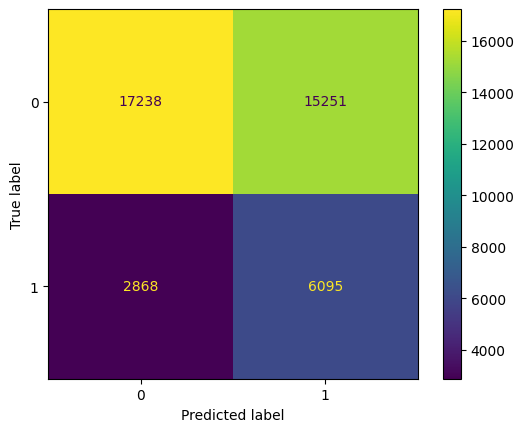

In [620]:
# Check the classification report and the confusion matrix

print(classification_report(y_true = y_test, y_pred = pred))

cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [621]:
# Let us look at label mappings to check what 0 and 1 mean
# Looks like "0" means NoDispute, and "1" means "Dispute"

print("Label mapping is:", labels)

Label mapping is: {0: 'No', 1: 'Yes'}


## Calculating Total Cost in Dollars    
The confusion matrix has 4 cells.  Each one has a different 'cost'.  Let us look at each:

> First cell (yellow cell, 1st row, 1st col): True NoDispute: Model predicted NoDispute, and customer did not dispute either.
> Here, we know we will pay $100 as "On average, it costs the banks \\$100 to resolve, respond to and close a complaint that is not disputed".

> Second cell (green cell, 1st row 2nd col): False Dispute: Model predicted Dispute and customer did not dispute.
> Here, we will end up investigating and performing additional due diligence at the cost of \\$90 over and above the $100 that has to be spent in any case.  So the cost of the entries in this cell are \\$190.

> Third cell (purple cell, 2nd row 1st col): False NoDispute: Model predicted NoDispute, but customer disputed.
> Here we will spend an extra \\$500 in addition to the \\$100, so there will be a total cost of \\$600.

> Fourth cell (blue cell, 2nd row, 2nd col): Model predicted Dispute, and customer actually disputed too.  
> Here we will spend the \\$90 for the cost of additional due diligence over and above the \\$100 that needs to be spent anyway.  So the total cost of any cases in this cell will be \\$190

Let us calculate the total cost based on our confusion matrix.  The confusion matrix has the false positives and the false negatives in the cells outside the main diagonal.  

In [622]:
# Cost when model predicts dispute and actually disputed
True_NoDispute_Cost = 100 * cm[0, 0]

# Cost when model predicts dispute and no actual dispute 
False_Dispute_Cost = 190 * cm[0,1]

# Cost when model predicts NoDispute and actually disputed
False_NoDispute_Cost = 600 * cm[1,0]

# Cost when model predicts NoDispute correctly
True_Dispute_Cost = 190 * cm[1,1]

In [623]:
Total_cost = True_NoDispute_Cost + False_Dispute_Cost + False_NoDispute_Cost + True_Dispute_Cost
Total_cost

7500340

## What should we do now?  

We are able to obtain the probability for a complaint being a "1" (which means 'yes').  The default is generally 0.5, which means if the probability of something being a dispute is more than 0.5, we consider it as 'yes', and if the prob is <0.5, we consider it a 'no'.  But we can change this threshold because we are very interested in finding future disputes even if we end up with more false positives.  This means we can play with the 0.5 threshold.  

On average, it costs the banks \\$100 to resolve, respond to and close a complaint that is not disputed .  On the other hand, it costs banks an extra \\$500 to resolve a complaint if it has been disputed.  

Our goal is to create and evaluate a predictive model that can help the banks identify future disputes so they can perform “extra diligence” during the first round of addressing the complaint with a view to avoiding eventual disputes.  If a complaint is picked up for “extra diligence”, it costs the bank an extra \\$90 to perform the additional diligence steps.  

It is clear that the cost of extra diligence is very low (\\$90), but if a complaint reaches the dispute stage, the cost can get quite high (\\$500).  So we would like to reduce false negatives from our predictive model, even if it means we push up false positives.  That is because the cost of false positives is quite low compared to the cost of false negatives.  

This means we want high recall, and are okay with a lower precision.  


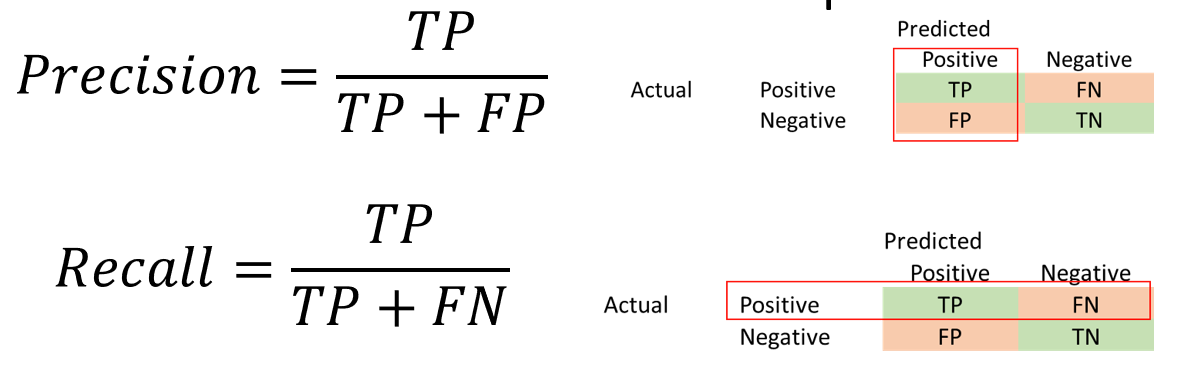    
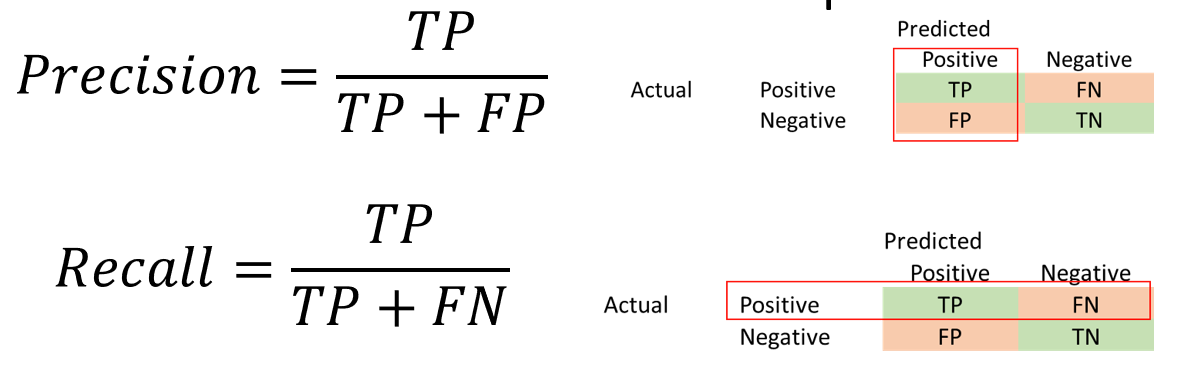  

We can look at our options using the ROC curve, but the ROC curve uses False Positive and True Positive rates (not precision and recall).  Roughly, we want a high True Positive rate (that minimizes FNs) and are okay if the False Positive rate goes up.  

Recall the formulae for TP and FP rates:  
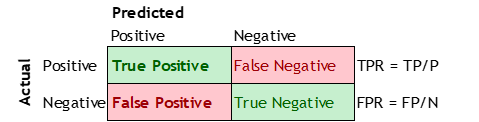

**This means we can play around with the threshold that decides what is marked as 'yes'.  Feel free to reduce this threshold on the next cell, and see if it helps you get better recall for category 1 (that may reduce accuracy, but that is okay).**   
## Adjusting the threshold  
Let us lower the threshold to a different value and see what happens to our confusion matrix, and if we can lower our total cost.



Confusion Matrix : 
 [[   52 32437]
 [    0  8963]]
Test accuracy =  0.21748045932644988
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     32489
           1       0.22      1.00      0.36      8963

    accuracy                           0.22     41452
   macro avg       0.61      0.50      0.18     41452
weighted avg       0.83      0.22      0.08     41452



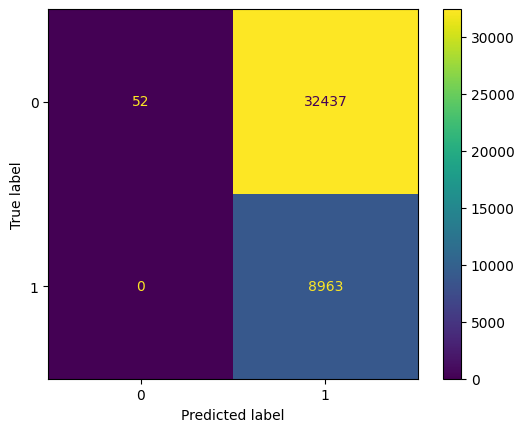

In [624]:
# Set threshold for identifying class 1
threshold = 0.1

# Create predictions.  Note that predictions give us probabilities, not classes!
pred_prob = model_xgb.predict_proba(X_test)

# We drop the probabilities for class 0, and keep just the second column
pred_prob = pred_prob[:,1]

# Convert probabilities to 1s and 0s based on threshold
pred = (pred_prob>threshold).astype(int)

# confusion matrix
cm = confusion_matrix(y_test, pred)
print ("Confusion Matrix : \n", cm)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, pred))
print(classification_report(y_true = y_test, y_pred = pred))

So we see that recall has gone up to 90% from a lower number earlier.

In [625]:
# See what predicted probabilities look like
pred_prob

array([0.5682963 , 0.6130641 , 0.5895082 , ..., 0.36399618, 0.46264127,
       0.48429078], dtype=float32)

In [626]:
pred

array([1, 1, 1, ..., 1, 1, 1])

In [627]:
# pred_prob = pred_prob[:,1]

**Calculating Total Cost in Dollars**  

Let us calculate the total cost based on our confusion matrix.  Just like we did before, no change to the logic.

In [629]:
# Cost when model predicts dispute and actually disputed
True_NoDispute_Cost = 100 * cm[0, 0]

# Cost when model predicts dispute and no actual dispute 
False_Dispute_Cost = 190 * cm[0,1]

# Cost when model predicts NoDispute and actually disputed
False_NoDispute_Cost = 600 * cm[1,0]

# Cost when model predicts NoDispute correctly
True_Dispute_Cost = 190 * cm[1,1]

In [630]:
Total_cost = True_NoDispute_Cost + False_Dispute_Cost + False_NoDispute_Cost + True_Dispute_Cost
Total_cost

7871200

Now you can see how you can play around with the threshold and change your total cost.  In fact, you could create a loop to go through many possibiities of thresholds and find out the optimal threshold that leads to the minimum cost.  

We do that in the next cell, running predictions by using the threshold value to be every value between 0 and 1 in increments of 0.01.  See that I use the library `tqdm` to get a nice looking progress bar at the bottom.  

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.68it/s]

CPU times: total: 2min 42s
Wall time: 37.4 s


<Axes: xlabel='threshold', ylabel='Total_cost'>

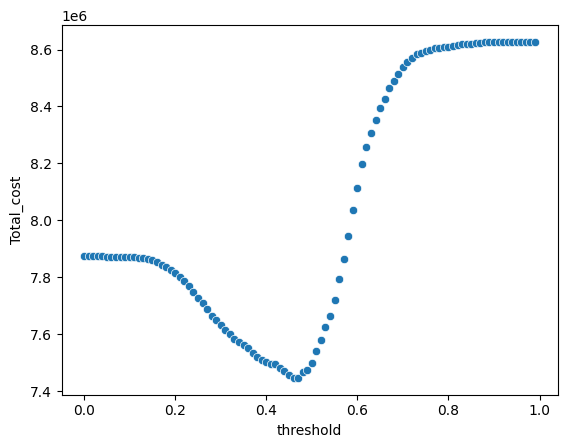

In [633]:
%%time
# Set threshold for identifying class 1
threshold = 0.1
appended_data = []

for threshold in tqdm(np.arange(0,1,.01)):
    # Create predictions.  Note that predictions give us probabilities, not classes!
    pred_prob = model_xgb.predict_proba(X_test)

    # We drop the probabilities for class 0, and keep just the second column
    pred_prob = pred_prob[:,1]

    # Convert probabilities to 1s and 0s based on threshold
    pred = (pred_prob>threshold).astype(int)

    # confusion matrix
    cm = confusion_matrix(y_test, pred)
    
    # accuracy score of the model
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred,zero_division=0)
    recall = recall_score(y_test, pred)
    
    # Cost when model predicts dispute and actually disputed
    True_NoDispute_Cost = 100 * cm[0, 0]

    # Cost when model predicts dispute and no actual dispute 
    False_Dispute_Cost = 190 * cm[0,1]

    # Cost when model predicts NoDispute and actually disputed
    False_NoDispute_Cost = 600 * cm[1,0]

    # Cost when model predicts NoDispute correctly
    True_Dispute_Cost = 190 * cm[1,1]
    
    Total_cost = True_NoDispute_Cost + False_Dispute_Cost + False_NoDispute_Cost + True_Dispute_Cost
    Total_cost
    
    data = pd.DataFrame({'threshold':[threshold], 'accuracy': [accuracy], 
                         'precision':[precision], 'recall':[recall],
                         'True_NoDispute_Cost':[True_NoDispute_Cost], 
                         'False_Dispute_Cost':[False_Dispute_Cost], 
                         'False_NoDispute_Cost':[False_NoDispute_Cost],
                         'True_Dispute_Cost':[True_Dispute_Cost],
                         'Total_cost':[Total_cost]})
    appended_data.append(data)
    
    

appended_data = pd.concat(appended_data)    

appended_data.reset_index()

# appended_data.to_excel('temp.xlsx')
sns.scatterplot(data = appended_data, y = 'Total_cost', x = 'threshold')

In [634]:
# At this point I can review the dataframe appended_data to find out the best threshold for minimizing cost
# Or I can do a simple query to list only the row that has the minumum cost by asking for
# appended_data[appended_data.Total_cost == appended_data.Total_cost.min()]
# I add some transpose and rounding to make it easier to read.

print(round(appended_data[appended_data.Total_cost == appended_data.Total_cost.min()].transpose(),3))

                                0
threshold                   0.460
accuracy                    0.470
precision                   0.265
recall                      0.820
True_NoDispute_Cost   1210900.000
False_Dispute_Cost    3872200.000
False_NoDispute_Cost   966000.000
True_Dispute_Cost     1397070.000
Total_cost            7446170.000


So my minimum cost occurs at a threshold of 0.46, and the cost is $7.47 mm.

## AUC and ROC calculation

In [635]:
# AUC calculation
from sklearn import metrics
metrics.roc_auc_score(y_test, pred_prob)

0.6485790587119202

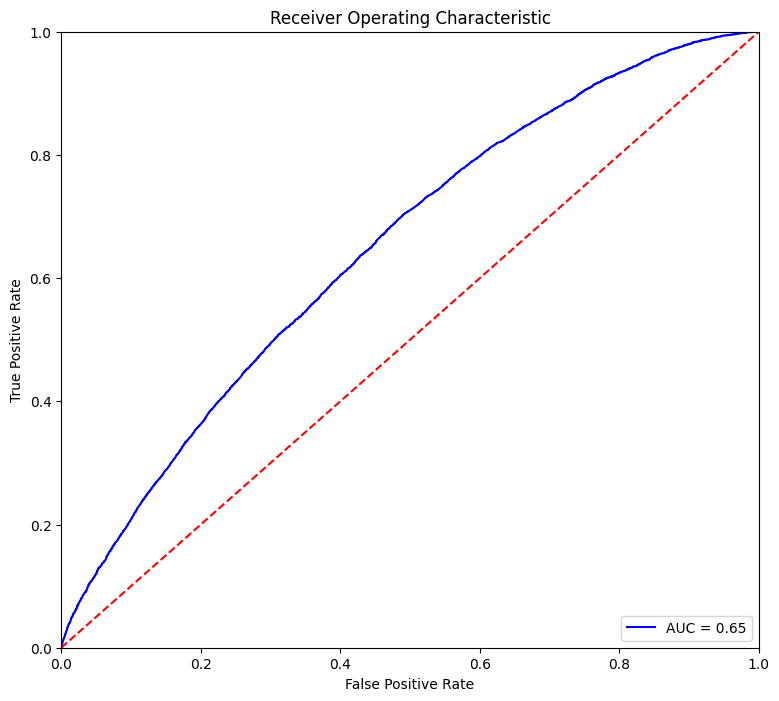

In [636]:
# Source for code below: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize = (9,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [637]:
pd.DataFrame({'TPR': tpr, 'FPR': fpr, 'Threshold': thresholds}).sort_values(by = ['Threshold']).reset_index(drop=True)

,TPR,FPR,Threshold
0,1.000000,1.000000,0.008539
1,1.000000,0.999723,0.019185
2,1.000000,0.999600,0.019882
3,1.000000,0.999261,0.026088
4,1.000000,0.999200,0.027471
...,...,...,...
13727,0.000558,0.000031,0.880111
13728,0.000446,0.000031,0.899356
13729,0.000446,0.000000,0.900411
13730,0.000112,0.000000,0.921485


In [638]:
# Save to Excel, just easier to see there.  No need to do this if you don't want to.
pd.DataFrame({'TPR': tpr, 'FPR': fpr, 'Threshold': thresholds}).sort_values(by = ['Threshold']).reset_index(drop=True).to_excel('temp.xlsx')

## What else?

At this point, we can experiment with the threshold to determine the lowest cost.  We will find it is related to our precision and recall calculations.  Hopefully, we can make an actionable recommendation to the Big Banks Board, and they will hire us for the job!

## Try a different model?

We only tried XGBoost, but we can try any other model that we learned.  We can also try to build a neural network for the prediction of customer disputes.  Maybe those give us better results.

Below we try logistic regression.  I have not done the total cost calculations, or the loop to determine the best threshold value for the below, but you can do it quite easily.

In [639]:
model = sm.Logit(y_train, X_train).fit(method='bfgs')
model.summary()

         Current function value: 0.673859
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


C:\Users\khush\anaconda3\envs\BApy\Lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\khush\anaconda3\envs\BApy\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                89806
Model:                          Logit   Df Residuals:                    89540
Method:                           MLE   Df Model:                          265
Date:                Fri, 28 Apr 2023   Pseudo R-squ.:                 0.02783
Time:                        19:53:59   Log-Likelihood:                -60517.
converged:                      False   LL-Null:                       -62249.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================================================================================================================================================
                                                                                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Product_Bank account or service                                                                                                                    -0.0299        nan        nan        nan         nan         nan
Product_Consumer Loan                                                                                                                               0.0076        nan        nan        nan         nan         nan
Product_Credit card                                                                                                                                 0.0946        nan        nan        nan         nan         nan
Product_Credit reporting                                                                                                                           -0.1120        nan        nan        nan         nan         nan
Product_Debt collection                                                                                                                            -0.1604        nan        nan        nan         nan         nan
Product_Money transfers                                                                                                                             0.0370        nan        nan        nan         nan         nan
Product_Mortgage                                                                                                                                   -0.0628        nan        nan        nan         nan         nan
Product_Other financial service                                                                                                                     0.0226        nan        nan        nan         nan         nan
Product_Payday loan                                                                                                                                -0.0330        nan        nan        nan         nan         nan
Product_Prepaid card                                                                                                                               -0.0418        nan        nan        nan         nan         nan
Product_Student loan                                                                                                                               -0.0505        nan        nan        nan         nan         nan
Sub-product_(CD) Certificate of deposit                                                                                                             0.1667        nan        nan        nan         nan         nan
Sub-product_Auto                                             

### Predict test set and evaluate  

**You can play with the threshold to get the right True Positive rate you desire!  The default generally is 0.50 but you can change it to lower values - eg, 0.2**   

In [640]:

# Set threshold for identifying class 1
threshold = 0.20

In [ ]:
# Create predictions.  Note that predictions give us probabilities, not classes!
pred_prob = model.predict(X_test)

# Convert probabilities to 1s and 0s based on threshold
pred = (pred_prob>threshold).astype(int)
 
# confusion matrix
cm = confusion_matrix(y_test, pred)
print ("Confusion Matrix : \n", cm)
 
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, pred))

In [ ]:
cm = confusion_matrix(y_test, pred)
pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])

In [ ]:
print(classification_report(y_true = y_test, y_pred = pred))

In [ ]:
# See what predicted probabilities look like
pred_prob

In [ ]:
# A histogram of probabilities.  Why not?
pred_prob.hist(bins=40)

### AUC and ROC calculation

In [ ]:
# AUC calculation
metrics.roc_auc_score(y_test, pred_prob)

In [ ]:
# Source for code below: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize = (9,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Dummy classifier code

In [ ]:
from sklearn.dummy import DummyClassifier
X = X_train
y = y_train
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
dummy_clf.score(X, y)

In [ ]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X, y)
dummy_clf.score(X, y)

In [ ]:
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X, y)
dummy_clf.score(X, y)

In [ ]:
pred = dummy_clf.predict(X_test)
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
# Check the classification report and the confusion matrix
print(classification_report(y_true = y_test, y_pred = pred))
ConfusionMatrixDisplay.from_estimator(dummy_clf, X = X_test, y = y_test, cmap='Greys');

In [ ]:
pred_prob = dummy_clf.predict(X_test)

In [ ]:
pred_prob